# **Brain Tumor Detection Using Thresholding Techniques**


This notebook presents a pipeline for **brain tumor detection** in MRI images, leveraging a series of processing techniques to accurately isolate the tumor region. The workflow includes the following key steps:

1. **Feature fusion**: Combining specific MRI modalities by multiplying them to enhance tumor visibility.
2. **Histogram analysis**: Visualizing the image histogram to select an appropriate threshold value.
3. **Thresholding**: Applying a combination of **Otsu** and manual thresholding to separate the tumor from surrounding tissues.
4. **Morphological operations**: Refining the segmentation mask using operations like erosion, dilation, and small object removal.
5. **Mask application**: Applying the generated mask to the MRI scan to isolate the tumor.

## **Objectives of the Notebook:**
- To develop a robust workflow for detecting brain tumors using a combination of modalities and image processing techniques.
- To create an accurate tumor mask that will be used in the next stage of the process, which involves segmenting the tumor into its subregions: **edema**, **enhancing tumor**, and **necrosis**.

Let's import libraries that we will use in this notebook.

In [1]:
import os
from glob import glob
import google.colab.drive as drive

import nibabel as nib
import numpy as np
from ipywidgets import interact,fixed
import matplotlib.pyplot as plt

from skimage import morphology, filters, color
from skimage.segmentation import expand_labels
from skimage.filters import threshold_multiotsu
from skimage.transform import rotate
from skimage.util import montage
%matplotlib inline

First, we mount the drive in Colab:

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Next, we extract the contents of the tar file, which contains the dataset files. The following command is used to extract the tar file:

In [ ]:
!tar -xvf "/content/drive/MyDrive/Task01_BrainTumour.tar"

let's load a sample that we will work on it to test our pipeline for the brain tumor detection

In [5]:
subject="BRATS_001"
im = nib.load('/content/Task01_BrainTumour/imagesTr/{}.nii.gz'.format(subject))
img_data = im.get_fdata()

This function is the one we used in the previous notebook to visualize the axial plan of MRI volume interactively.

In [67]:
# Define a function to visualize the data
def explore_4dimage_axial(layer,MRI_Seq,input_data):
    plt.figure(figsize=(10, 5))
    plt.imshow(input_data[:, :, layer,MRI_Seq], cmap='gray', origin="lower");
    plt.title(f'Axial Plane - Layer {layer}', fontsize=16)
    plt.axis('off')
    plt.show()

# Run the ipywidgets interact() function to explore the data
interact(explore_4dimage_axial, layer=(0,img_data.shape[2]-1), MRI_Seq=(0,img_data.shape[3]-1), input_data=fixed(img_data));

interactive(children=(IntSlider(value=77, description='layer', max=154), IntSlider(value=1, description='MRI_S…

The following function is a modified version of `explore_4dimage_axial`, designed to handle 3D arrays instead of 4D arrays. It enables the visualization of slices in the axial plane.

In the previous notebook, the fourth dimension corresponded to different MRI modalities (FLAIR, T1, T1ce, T2), but here we only require the 3D version of the function. We'll explain the reasons for this later.

In [68]:
# Define a function to visualize the data
def explore_3dimage_axial(layer,input_data):
    plt.figure(figsize=(10, 5))
    plt.imshow(input_data[:,:, layer], cmap='gray', origin='lower');
    plt.title(f'Axial Plane - Layer {layer}', fontsize=16)
    plt.axis('off')
    #plt.colorbar(label='Signal intensity',use_gridspec= False)
    plt.show()

We will use this visualization function `display_volume_slices` to get an idea of consecutive slices of the MRI volume on a grid way.

In [8]:
def display_volume_slices(volume, start_slice=66, num_slices=10, num_rows=2, num_cols=5, cmap="gray"):
  """
  Displays a grid of slices from a 3D volume.

  Args:
    volume: The 3D volume data (NumPy array).
    start_slice: The index of the first slice to display.
    num_slices: The number of consecutive slices to display.
    cmap: The colormap to use for visualization.
  """
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))  # Adjust rows/cols as needed

  for i in range(num_slices):
      ax = axes[i // num_cols, i % num_cols]  # Get the correct subplot
      ax.imshow(volume[:, :, start_slice + i], cmap=cmap, origin="lower")
      ax.axis('off')

  plt.tight_layout()  # Improves spacing between subplots
  plt.show()

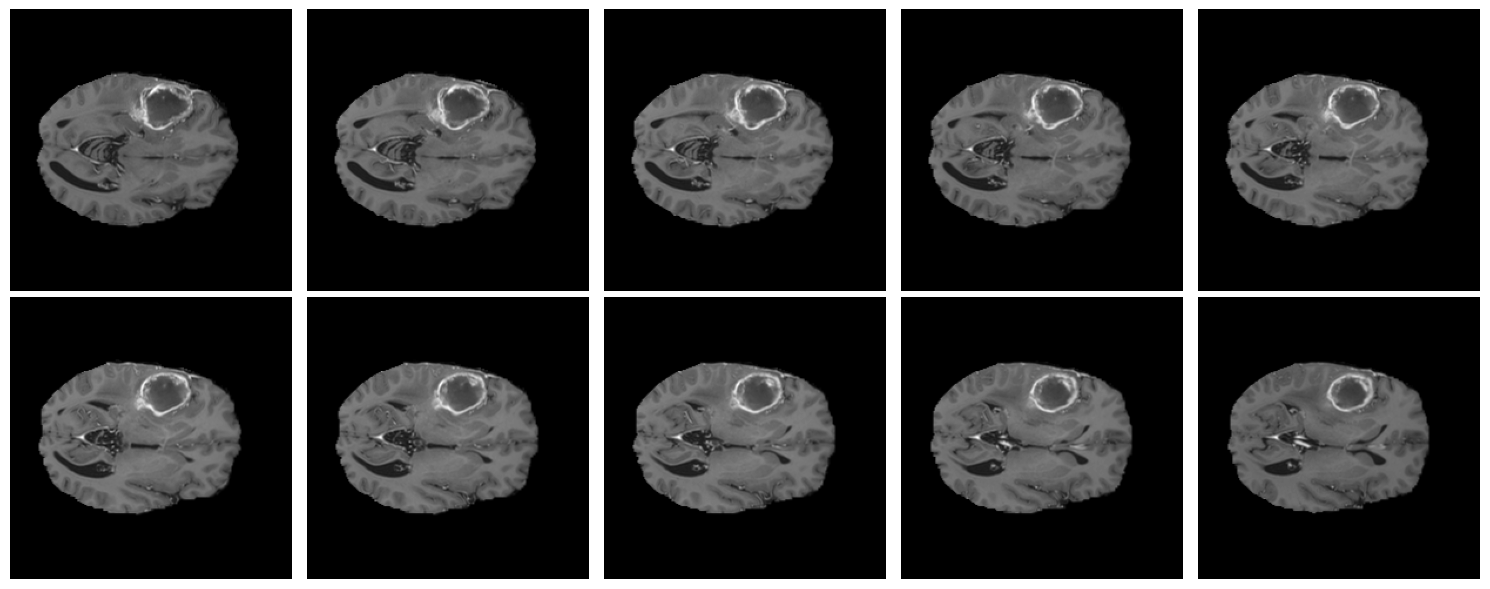

In [9]:
display_volume_slices(img_data[:,:,:,2], start_slice=66, num_slices=10)

## **Feature Fusion: Combining Multiple MRI Modalities**

In this section, we combine different MRI modalities by multiplying their voxel intensities. This approach leverages the strengths of each modality to enhance the contrast in regions of interest, such as tumors. The following modalities are included in the `img_data`:

- **FLAIR Image** (`img_data[:, :, :, 0]`): This modality suppresses signals from fluids, such as cerebrospinal fluid, and highlights lesions. It is especially effective at showing areas of abnormality such as edema or tumor-associated inflammation.

- **T1ce Image** (`img_data[:, :, :, 2]`): The T1-weighted image with contrast enhancement is critical for visualizing areas where the blood-brain barrier is compromised, which is often indicative of tumor presence. The contrast enhancement highlights these abnormal areas more distinctly.

- **T2-weighted Image** (`img_data[:, :, :, 3]`): The T2-weighted image highlights areas with increased fluid, such as edema or cystic components of tumors. This is important for understanding the extent of swelling around the tumor.

This approach unable us to:

1. **Enhance Tumor Visibility**:
   Each modality provides a different perspective on the brain's tissue structures. By multiplying the FLAIR, T1ce, and T2-weighted images, we emphasize regions where the tumor appears in all three modalities. Tumors often exhibit high intensity in these regions, and this combination can help delineate tumor boundaries more clearly.

2. **Create an Intersection of Features**:
   The multiplication of different channels acts as a form of intersection between these images. Only regions with significant intensities in all modalities will remain prominent, suppressing low-intensity areas. This allows us to focus on areas with consistent abnormalities across the modalities.

3. **Suppress Noise**:
   Multiplying channels can help reduce noise and background artifacts that may appear in only one modality. By focusing on regions that show consistent abnormalities across FLAIR, T1ce, and T2, we reduce the risk of false positives in areas where noise may be present in a single channel.

This approach is a form of feature fusion, where multiple sources of information (different MRI modalities) are combined to provide a richer, more detailed representation of the brain, enhancing tumor detection and segmentation accuracy.

The following operations combine these modalities in two different ways:

In [10]:
# First combination method
fused_mod_img = img_data[:, :, :, 0] * img_data[:, :, :, 2] * img_data[:, :, :, 3] * (10**-6)

# Second combination method with bias added to the T1ce image
fused_mod_biased_img = img_data[:, :, :, 0] * (img_data[:, :, :, 2] + 2000) * img_data[:, :, :, 3] * (10**-6)

### **Visualization of Combined Images**

To compare the effects of these two combinations, we visualize the generated images. The first combination (`fused_mod_img`) is a simple multiplication of the FLAIR, T1ce, and T2-weighted images. The second combination (`fused_mod_biased_img`) introduces a bias by adding `2000` to the T1ce image before multiplication. This bias shifts the intensity of the T1ce image, ensuring it contributes more prominently to the combined image.

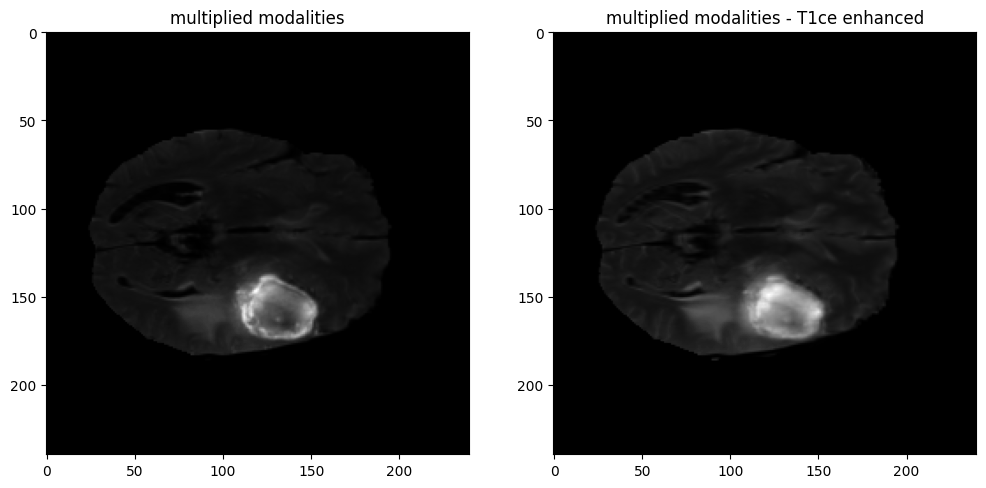

In [11]:
slice_idx = 70
# Visualization of fused_mod_img and fused_mod_biased_img
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('multiplied modalities')
plt.imshow(fused_mod_img[:,:,slice_idx], cmap='gray')

plt.subplot(1, 2, 2)
plt.title('multiplied modalities - T1ce enhanced')
plt.imshow(fused_mod_biased_img[:,:,slice_idx], cmap='gray')

plt.show()


After visualizing both combined images, we chose to proceed with the second combination (`fused_mod_biased_img`) for the following reasons:

- **Bias in the T1ce Image**: By adding `2000` to the T1ce image, we increase its intensity across the image, ensuring that regions highlighted by contrast enhancement (such as tumors) are more prominently featured in the combined image. This bias helps to balance the influence of the different modalities, particularly when the T1ce intensity values are lower than those in FLAIR or T2.

- **Enhanced Tumor Visibility**: The combination of FLAIR, biased T1ce, and T2-weighted images effectively enhances regions where the tumor is present in all modalities. This combined image allows us to better identify the tumor as the combination ensures that abnormal areas are highlighted in multiple modalities.

The chosen combination method provides better contrast and detail for regions of interest, enhancing tumor detection in the subsequent analysis steps. The resulting image is shown below:

**1. Interactive visualisation of the entire volume**

In [69]:
interact(explore_3dimage_axial, layer=(0,fused_mod_biased_img.shape[2]-1), input_data=fixed(fused_mod_biased_img));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

**2. Display of volume slices from 66 to 76**

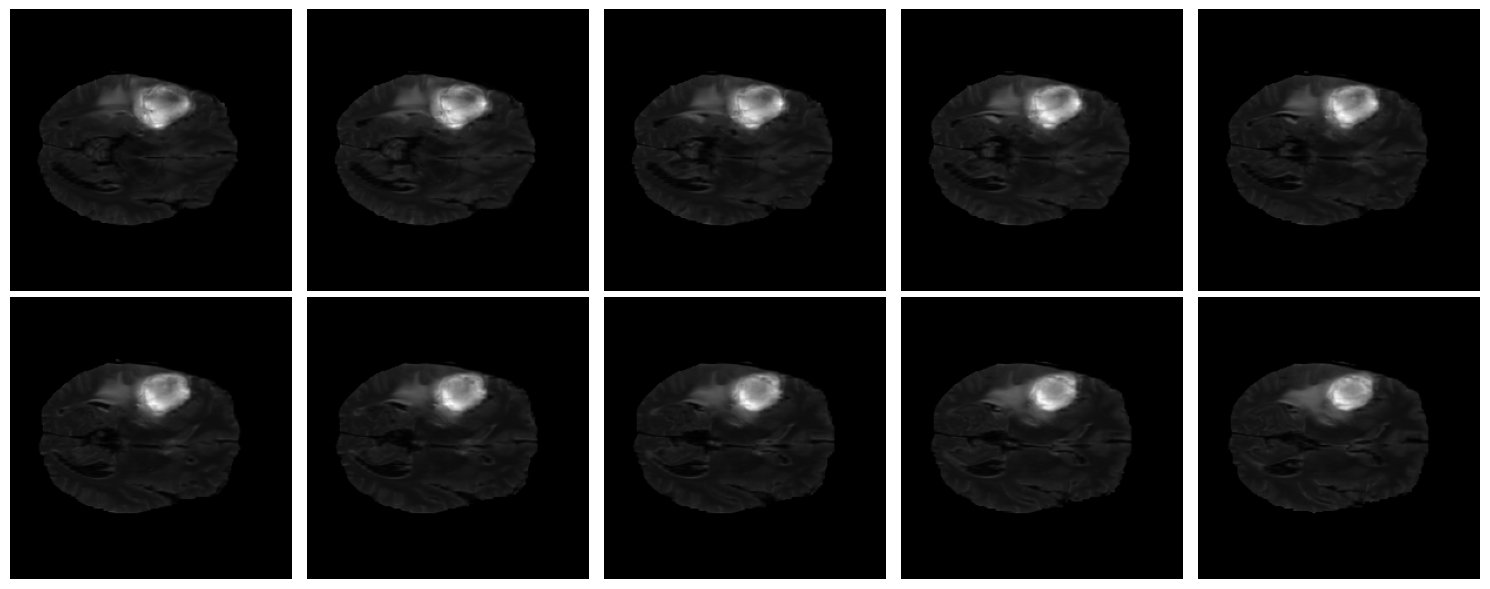

In [13]:
display_volume_slices(fused_mod_biased_img, start_slice=66, num_slices=10)

## **Tumor Detection**

In the following section, we will use thresholding to detect the tumor after enhancing the tumoral region through a feature fusion process, which combines selected MRI modalities.

### **Histogram Analysis**

Before thresholding, it's informative to examine the intensity distribution of the 3D image:

1. **Whole Volume Histogram:** We compute and plot the histogram of the entire 3D image, considering all axial slices. This provides an overview of the intensity values present in the dataset.

interactive(children=(Output(),), _dom_classes=('widget-interact',))

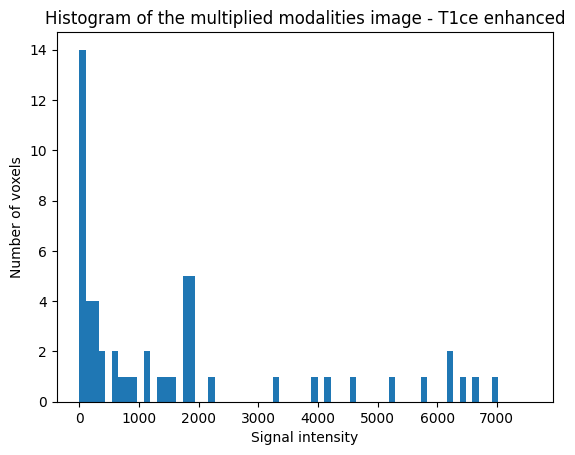

In [71]:
#define a function to explore the histogram of 3D image of axial slices of the brain
def explore_3dimage_histogram(input_data):
    histo, bin_edges = np.histogram(input_data[50:195,20:202,10:142], bins=70)
    _ = plt.hist(histo, bins=bin_edges)
    plt.title('Histogram of the multiplied modalities image - T1ce enhanced')
    plt.xlabel("Signal intensity")
    plt.ylabel("Number of voxels")

# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage_histogram, input_data=fixed(fused_mod_biased_img));

2. **Layer-wise Histogram:** Additionally, we analyze the histogram of each axial slice individually. This per-layer examination reveals variations in intensity distributions across different slices, which can inform the thresholding process.

In [73]:
#define a function to explore histogram of 3D image of axial slices of the brain per layer
def explore_3dimage_histo_per_layer(layer,input_data):
    img1=input_data[50:195,20:202,layer]
    histo, bin_edges = np.histogram(img1, bins=15)
    _, axis = plt.subplots(ncols=2, figsize=(12, 3))
    axis[0].imshow(img1,'gray',origin='lower')
    axis[0].set_title(f'Axial Plane - Layer {layer}')
    axis[0].axis('off')
    axis[1].hist(histo, bins=bin_edges)
    axis[1].set_title(f'Histogram of slice{layer}')
    axis[1].set_xlabel("Signal intensity")
    axis[1].set_ylabel("Number of voxels")
    plt.show()

# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage_histo_per_layer, layer=(0,fused_mod_biased_img.shape[2]-1), input_data=fixed(fused_mod_biased_img))

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

<function __main__.explore_3dimage_histo_per_layer(layer, input_data)>

Visualizing these histograms helps identify the number of distinct intensity peaks, guiding the selection of thresholding parameters.

Since the image has a black background, most of the pixels are near zero intensity, which is reflected in the histogram as a peak close to 0. Regions with low intensity are generally in the range of 0 to 1000. To isolate the tumor, we need to exclude the black background and low-intensity pixels while keeping the higher-intensity pixels associated with the tumoral region. Therefore, we should select a threshold value above the low-intensity range. For this purpose, we will use a threshold of **t = 1300**.

### **Thresholding: Applying Multi-Otsu Thresholding**

We applied the Multi-Otsu thresholding method to segment the 3D image. The Otsu's method is a widely used technique for automatic image thresholding. It determines an optimal threshold value that minimizes the within-class variance of the thresholded pixels, effectively separating the image into distinct regions.

Multi-Otsu extends this concept to segment the image into multiple distinct classes based on intensity levels by finding multiple threshold values.


In [32]:
#threshold
t = 1300
# Applying multi-Otsu threshold for the default value, generating classes.
thresholds = threshold_multiotsu(fused_mod_biased_img)
# Using the thresholds, we generate the regions.
regions = np.digitize(fused_mod_biased_img, bins=thresholds)
# create the binary mask using manual thresholding
detected_tumor_region = ((regions*fused_mod_biased_img) > t).astype(np.float64) #np.where(newImg_data > t, 1, 0)
# Visualize the result
interact(explore_3dimage_axial, layer=(0,detected_tumor_region.shape[2]-1), input_data=fixed(detected_tumor_region));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

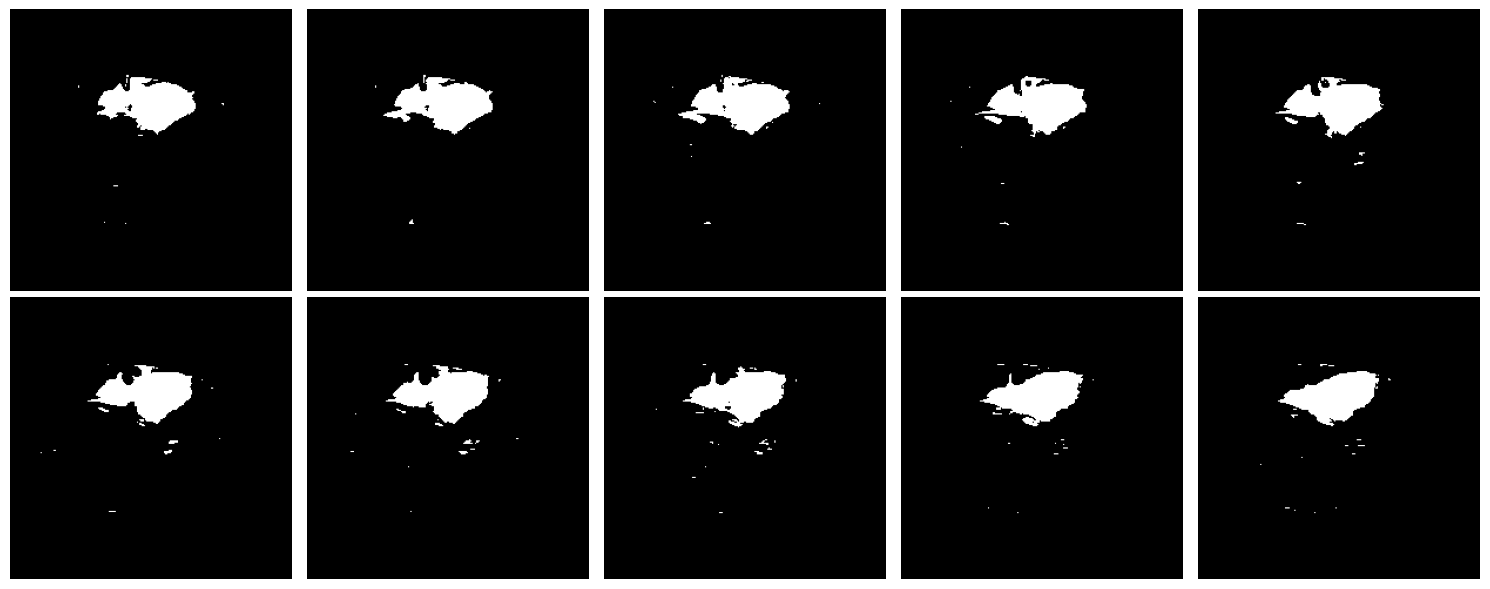

In [33]:
display_volume_slices(detected_tumor_region, start_slice=66, num_slices=10)


The binary mask obtained from the Otsu thresholding as you can see above contains noise and small disconnected regions that are not part of the tumor. In the subsequent step, we will apply **mathematical morphology operations** to refine the mask and improve the segmentation accuracy.

### **Post-Processing of the Binary Mask: Mathematical Morphology Operations**

After generating the binary mask, the next step involves refining the segmented image through **mathematical morphology operations**. These operations are typically used to remove noise, fill small holes, and smooth the boundaries of the segmented regions. These operations help in creating a cleaner and more accurate mask that can be used for further analysis.

The most common **morphology operations** used for this purpose include:

- **Erosion:** Removes small isolated regions or noise from the mask.
- **Dilation:** Fills in small gaps or holes within the mask.
- **Opening and Closing:** These are combinations of erosion and dilation used to smooth the object’s boundaries and enhance the quality of the segmented region.

The folowing is the pipeline we end up with after several experiments to refine the detected tumor region mask:

In [42]:
# Step 1: Binary closing to fill small holes in the binary mask
img_closed=morphology.binary_closing(detected_tumor_region)

# Step 2: Remove small objects with a minimum size threshold
img_no_small_object1=morphology.remove_small_objects(img_closed,min_size=80)

# Step 3: Apply binary erosion to refine the mask
erosed_img=morphology.binary_erosion(img_no_small_object1)

# Step 4: Remove small objects again after erosion
img_no_small_object2=morphology.remove_small_objects(erosed_img,min_size=100)

# Step 5: Apply binary erosion again to further refine the mask
erosed_img1=morphology.binary_erosion(img_no_small_object2)

# Step 6: Remove small objects again after the second erosion
img_no_small_object3=morphology.remove_small_objects(erosed_img1,min_size=100)

# Step 7: Create a spherical structuring element for binary dilation
footprint = morphology.ball(2)

# Step 8: Apply binary dilation to expand the regions
dilated_img=morphology.binary_dilation(img_no_small_object3,footprint)

# Step 9: Apply binary closing again to smooth the final mask
tumor_mask_res = morphology.binary_closing(dilated_img)

interact(explore_3dimage_axial, layer=(0,tumor_mask_res.shape[2]-1), input_data=fixed(tumor_mask_res));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

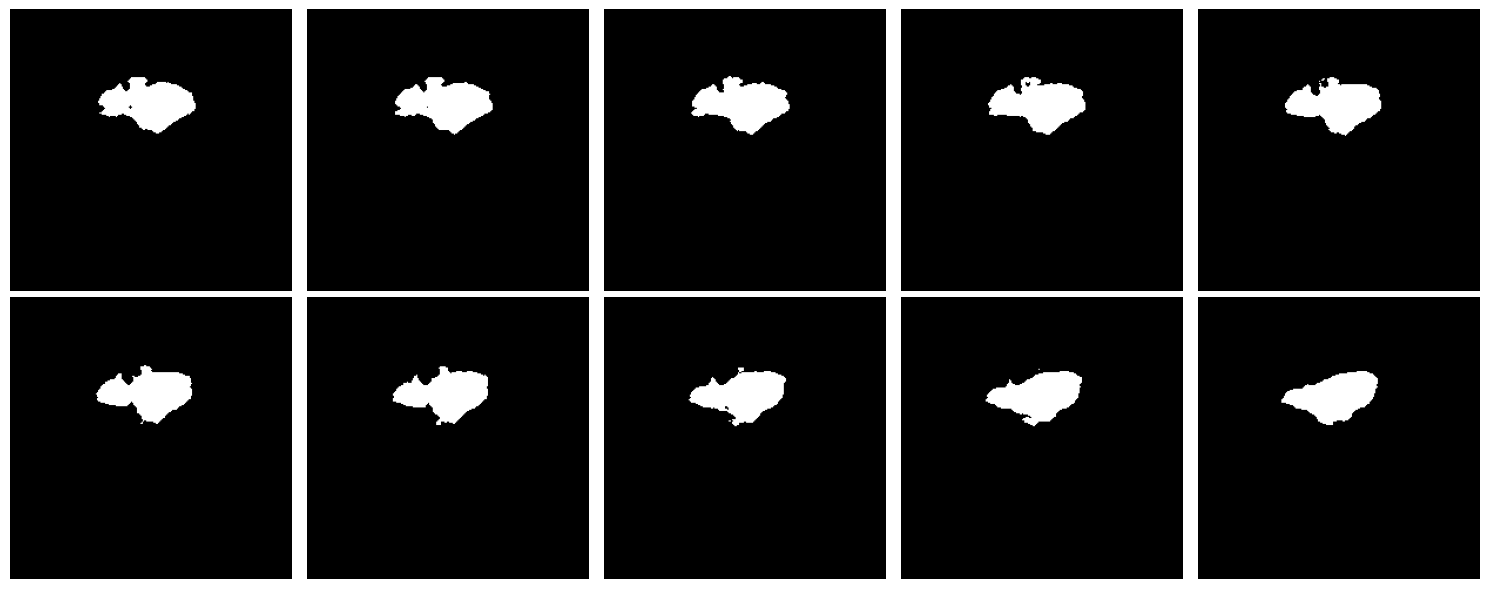

In [43]:
display_volume_slices(tumor_mask_res, start_slice=66, num_slices=10)

### **Mask Application**
In this step, we apply the tumor mask generated from the thresholding process to the MRI scan to isolate the tumor.

In [45]:
tumor_data = img_data[:,:,:,:] * tumor_mask_res[:,:,:,np.newaxis]

interact(explore_4dimage_axial, layer=(0,img_data.shape[2]-1), MRI_Seq=(0,img_data.shape[3]-1), input_data=fixed(tumor_data));

interactive(children=(IntSlider(value=77, description='layer', max=154), IntSlider(value=1, description='MRI_S…

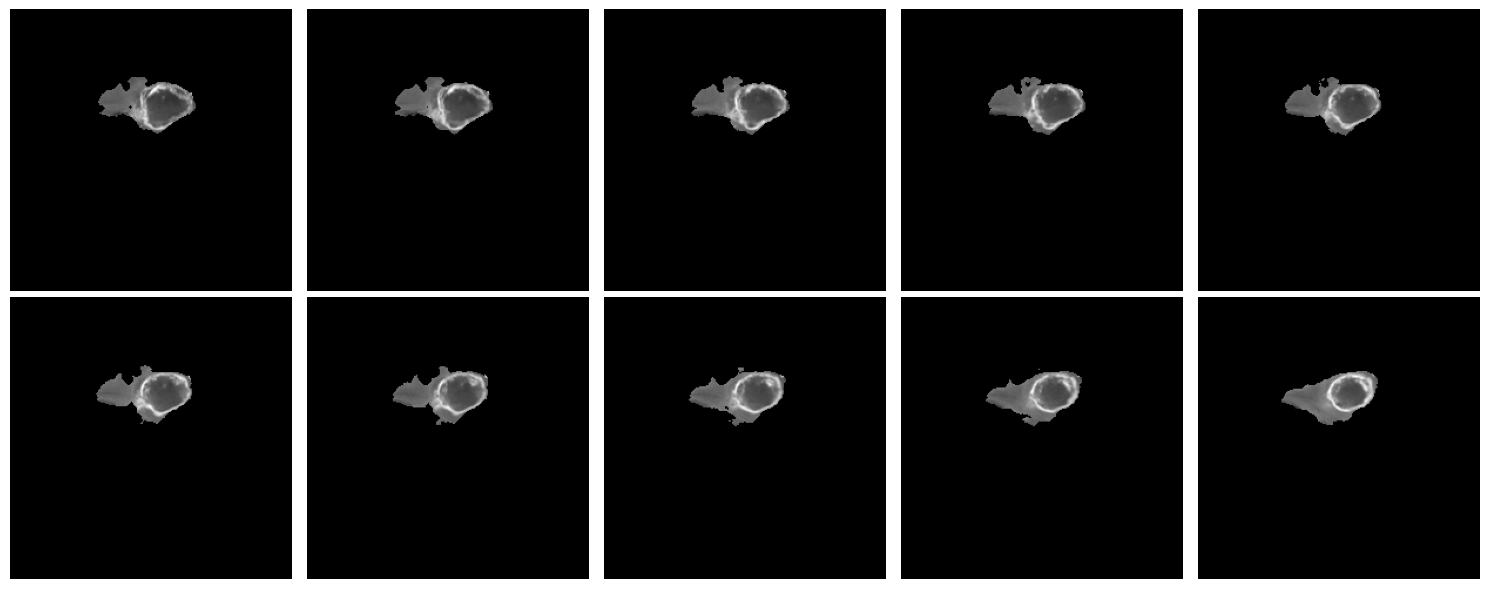

In [46]:
mri_modality=2
display_volume_slices(tumor_data[:,:,:,mri_modality], start_slice=66, num_slices=10)

Once the mask is applied, we can save the resulting segmented tumor volume as a NIfTI file, preserving the original brain volume’s metadata (affine transformations and headers) for compatibility with subsequent analysis tools.

This step ensures that the segmented tumor is stored in a format that retains spatial orientation and other important details from the original MRI scan.

In [47]:
tumor = nib.Nifti1Image(tumor_data, im.affine, im.header)
#print(type(tumor),'\n',tumor.shape,'\n',tumor.header)
nib.save(tumor,'/content/Detected_Tumor_Region_{}.nii.gz'.format(subject))

## **Conclusion**

In this notebook, we developed and implemented a pipeline for **brain tumor detection** in MRI images. By combining MRI modalities through feature fusion, visualizing the image histograms, and applying both **Otsu** and manual thresholding techniques, we were able to detect and isolate the tumor region. Morphological operations helped refine the segmentation mask, leading to a cleaner and more precise identification of the tumor boundaries.

This foundational step sets the stage for the next phase, where we will segment the tumor into its key subregions: **edema**, **enhancing tumor**, and **necrosis**.